## Notation

1. $k$ — number of actions (arms)  
2. $t$ — discrete time step (or play number)  
3. $q_*(a)$ — true (expected) reward of action $a$  
4. $Q_t(a)$ — estimate at time $t$ of $q_*(a)$  
5. $N_t(a)$ — number of times action $a$ has been selected up to (but not including) time $t$  
6. $H_t(a)$ — learned preference for selecting action $a$ at time $t$  
7. $\pi_t(a)$ — probability of selecting action $a$ at time $t$  
8. $\overline{R}_t$ — estimate at time $t$ of the expected reward under $\pi_t$  
9. $R_i$ — reward received on the $i$th selection of a particular action  
10. $Q_n$ — value estimate of an action after it has been chosen $n-1$ times (i.e., the average of its first $n-1$ rewards)

---

## 1. The $k$-Armed Bandit Problem

- We have $k$ possible actions (arms).  
- On each time step $t$:
  - We choose an action $A_t$.  
  - We receive a numerical reward $R_t$.  
- Each action $a$ has a true but unknown expected reward $q_*(a)$.  
- Our **goal**: choose actions over many trials to **maximize** total reward. This requires balancing:
  - **Exploitation**: picking the action that currently appears best.
  - **Exploration**: trying out other actions to refine estimates.

---

## 2. Action-Value Methods

We maintain a running **action-value estimate** $Q_t(a)$ for each action $a$. One simple approach is the **sample-average** method:

$$
Q_t(a)=\frac{\sum_{i=1}^{t-1} R_i \,\mathbf{1}_{\{A_i = a\}}}
     {\sum_{i=1}^{t-1} \mathbf{1}_{\{A_i = a\}}} \quad (\text{if never chosen, use a default like }0)
$$

As the number of samples grows large, by the law of large numbers, $Q_t(a)$ converges to $q_*(a)$.

### 2.1 Greedy and $\varepsilon$-Greedy Action Selection

1. **Greedy**: always pick

   $$
   A_t=\arg\max_a \, Q_t(a)
   $$
   
   This **exploits** our current knowledge but does not explore less-tried actions.

2. **$\varepsilon$-Greedy**:  
   - With probability $1-\varepsilon$, select the greedy action (max $Q_t(a)$).  
   - With probability $\varepsilon$, select an action **at random**.  
   - Ensures **infinite exploration** of each action in the limit.  
   - Probability of picking the true optimal arm $\to 1-\varepsilon$ as $t\to\infty$.

---

## 3. Incremental Implementation of Sample Averages

Rather than storing **all** past rewards, we can update the average **incrementally** in constant time. Let:

- $Q_n$ be the average of the first $n-1$ rewards of one particular action.
- $R_n$ be the **new** (i.e., $n$-th) observed reward for that action.
- $Q_{n+1}$ be the updated average (now covering $n$ rewards).

### 3.1 Derivation

1. By definition of $Q_{n+1}$:
   $$
   \begin{align*}
   Q_{n+1}&=\frac{1}{n}\sum_{i=1}^{n} R_i \\
          &=\frac{1}{n}(R_n + \sum_{i=1}^{n-1}R_i)
   \end{align*}
   $$

2. Note that:
   $$
   \begin{align*}
   \sum_{i=1}^{n-1} R_i&=(n-1)\,\frac{1}{n-1}\sum_{i=1}^{n-1} R_i \\
                       &=(n-1)\,Q_n
   \end{align*}
   $$

3. Substitute back:
   $$
   Q_{n+1}=\frac{1}{n}(R_n + (n-1)Q_n)
   $$

4. Distribute $\frac{1}{n}$:
   $$
   \begin{align*}
   Q_{n+1}&=\frac{1}{n}(R_n + nQ_n - Q_n) \\
         &=\frac{R_n}{n} + \frac{\cancel{n}Q_n}{\cancel{n}} - \frac{Q_n}{n} \\
         &=Q_n + \frac{R_n - Q_n}{n} \\
         &=Q_n + \frac{1}{n}(R_n - Q_n)
   \end{align*}
   $$

Thus,

$$
Q_{n+1}=Q_n + \frac{1}{n}(R_n - Q_n)
$$

This shows that **only the old estimate, the new reward, and the count $n$ are needed** to update the average in $O(1)$ time.

<center>
    <img src="diagrams/simple_bandit_algorithm.png" width="70%">
</center>

In [2]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import polars as pl
from action_value_methods import main

In [3]:
# Define a sequence of actions (1-based index) and rewards
actions = [1, 2, 2, 2, 3, 4, 4, 3, 1, 2, 3, 3]
rewards = [-1, 1, -2, 2, 0, 1, -1, 2, 0, 1, -2, 2]

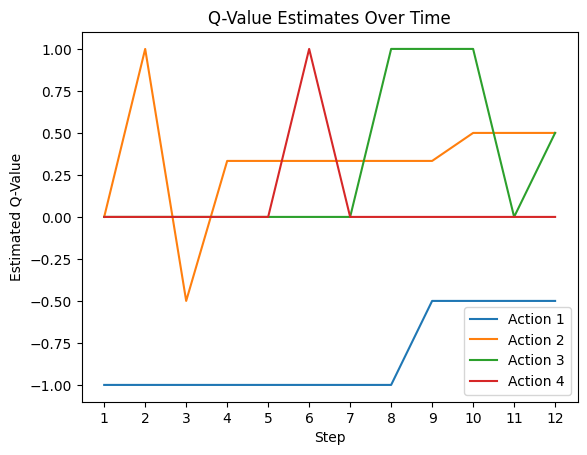

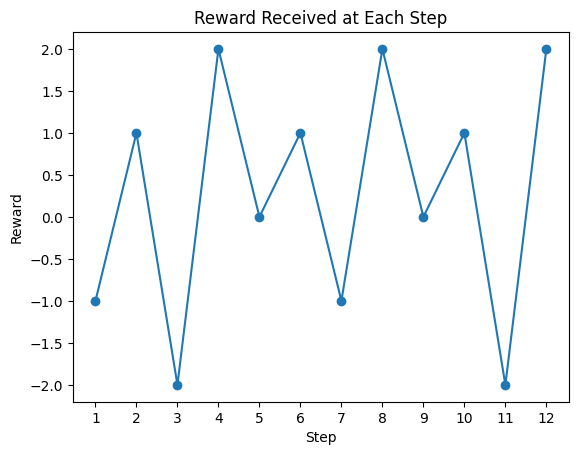

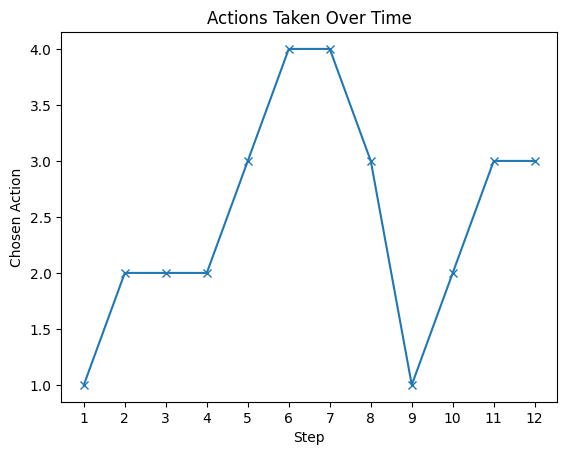

In [4]:
step_analysis_data, q_value_data, summary_data = main(
    print_tables=False,
    show_plots=True,
    actions=actions,
    rewards=rewards,
)

In the table below, the "Greedy Set Before Step" column shows the actions that have the highest estimated value before taking the action at that step. If there is a tie, all tied actions are included in the greedy set. This should match the Q values in the second table at each corresponding step.

In [6]:
with pl.Config(tbl_rows=len(step_analysis_data)):
    step_analysis_data

with pl.Config(tbl_rows=len(q_value_data)):
    q_value_data

with pl.Config(tbl_rows=len(summary_data)):
    summary_data

Step,Chosen Action,Reward,Greedy Set Before Step,Must be Epsilon?,Possibly Epsilon?
i64,i64,i64,list[i64],str,str
1,1,-1,"[1, 2, … 4]","""No""","""Yes"""
2,2,1,"[2, 3, 4]","""No""","""Yes"""
3,2,-2,[2],"""No""","""Yes"""
4,2,2,"[3, 4]","""Yes""","""No"""
5,3,0,[2],"""Yes""","""No"""
6,4,1,[2],"""Yes""","""No"""
7,4,-1,[4],"""No""","""Yes"""
8,3,2,[2],"""Yes""","""No"""
9,1,0,[3],"""Yes""","""No"""


Step,Chosen,Reward,Q1,Q2,Q3,Q4
i64,i64,i64,f64,f64,f64,f64
1,1,-1,-1.0,0.0,0.0,0.0
2,2,1,-1.0,1.0,0.0,0.0
3,2,-2,-1.0,-0.5,0.0,0.0
4,2,2,-1.0,0.33,0.0,0.0
5,3,0,-1.0,0.33,0.0,0.0
6,4,1,-1.0,0.33,0.0,1.0
7,4,-1,-1.0,0.33,0.0,0.0
8,3,2,-1.0,0.33,1.0,0.0
9,1,0,-0.5,0.33,1.0,0.0


Action,Final Q-Value,Times Selected,Average Reward
i64,f64,i64,f64
1,-0.5,2,-0.5
2,0.5,4,0.5
3,0.5,4,0.5
4,0.0,2,0.0
